In [1]:
import os
import http
import copy
import random
import torch
# import torchvision
# import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

import backwardcompatibilityml.loss as bcloss
import backwardcompatibilityml.scores as scores
from backwardcompatibilityml.helpers import training
from backwardcompatibilityml.widgets import CompatibilityAnalysis

# Turn off warnings so that the widget screen
# real estate does not decrease.
import warnings
warnings.filterwarnings("ignore")

# Initialize random seed
random.seed(123)
torch.manual_seed(456)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

%matplotlib inline

In [2]:
# age: continuous.
# workclass: (8) Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: (16) Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: (7) Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: (14) Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: (6) Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: (5) White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: (2) Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: (41) United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.



In [3]:
if not os.path.isdir("datasets/adult-uci"):
    os.mkdir("datasets/adult-uci")

http_client = http.client.HTTPSConnection("archive.ics.uci.edu")
http_client.request("GET", "/ml/machine-learning-databases/adult/adult.data")
response = http_client.getresponse()
data = response.read().decode("utf-8")
data_file = open("datasets/adult-uci/adult.data", "w")
data_file.write(data)
data_file.close()

In [4]:
datafile = open("datasets/adult-uci/adult.data", "r")
raw_data = datafile.read()
datafile.close()

In [5]:
import pandas as pd
df = pd.read_csv("datasets/adult-uci/adult.data")

In [6]:
df.loc[10:20]

39          State-gov   77516    Bachelors   13        Never-married  \
10  30          State-gov  141297    Bachelors   13   Married-civ-spouse   
11  23            Private  122272    Bachelors   13        Never-married   
12  32            Private  205019   Assoc-acdm   12        Never-married   
13  40            Private  121772    Assoc-voc   11   Married-civ-spouse   
14  34            Private  245487      7th-8th    4   Married-civ-spouse   
15  25   Self-emp-not-inc  176756      HS-grad    9        Never-married   
16  32            Private  186824      HS-grad    9        Never-married   
17  38            Private   28887         11th    7   Married-civ-spouse   
18  43   Self-emp-not-inc  292175      Masters   14             Divorced   
19  40            Private  193524    Doctorate   16   Married-civ-spouse   
20  54            Private  302146      HS-grad    9            Separated   

          Adm-clerical   Not-in-family                White     Male   2174  \
10      Prof-specialty         Husband   Asian-Pac-Islander     Male      0   
11        Adm-clerical       Own-child                White   Female      0   
12               Sales   Not-in-family                Black     Male      0   
13        Craft-repair         Husband   Asian-Pac-Islander     Male      0   
14    Transport-moving         Husband   Amer-Indian-Eskimo     Male      0   
15     Farming-fishing       Own-child                White     Male      0   
16   Machine-op-inspct       Unmarried                White     Male      0   
17               Sales         Husband                White     Male      0   
18     Exec-managerial       Unmarried                White   Female      0   
19      Prof-specialty         Husband                White     Male      0   
20       Other-service       Unmarried                Black   Female      0   

     0   40   United-States   <=50K  
10   0   40           India    >50K  
11   0   30   United-States   <=50K  
12   0   50   United-States   <=50K  
13   0   40               ?    >50K  
14   0   45          Mexico   <=50K  
15   0   35   United-States   <=50K  
16   0   40   United-States   <=50K  
17   0   50   United-States   <=50K  
18   0   45   United-States    >50K  
19   0   60   United-States    >50K  
20   0   20   United-States   <=50K

In [7]:
dfr = df.rename(columns={" <=50K": "income", " 77516": "fnlwgt"})

In [8]:
dfr

39          State-gov  fnlwgt    Bachelors   13        Never-married  \
0      50   Self-emp-not-inc   83311    Bachelors   13   Married-civ-spouse   
1      38            Private  215646      HS-grad    9             Divorced   
2      53            Private  234721         11th    7   Married-civ-spouse   
3      28            Private  338409    Bachelors   13   Married-civ-spouse   
4      37            Private  284582      Masters   14   Married-civ-spouse   
...    ..                ...     ...          ...  ...                  ...   
32555  27            Private  257302   Assoc-acdm   12   Married-civ-spouse   
32556  40            Private  154374      HS-grad    9   Married-civ-spouse   
32557  58            Private  151910      HS-grad    9              Widowed   
32558  22            Private  201490      HS-grad    9        Never-married   
32559  52       Self-emp-inc  287927      HS-grad    9   Married-civ-spouse   

             Adm-clerical   Not-in-family   White     Male   2174   0   40  \
0         Exec-managerial         Husband   White     Male      0   0   13   
1       Handlers-cleaners   Not-in-family   White     Male      0   0   40   
2       Handlers-cleaners         Husband   Black     Male      0   0   40   
3          Prof-specialty            Wife   Black   Female      0   0   40   
4         Exec-managerial            Wife   White   Female      0   0   40   
...                   ...             ...     ...      ...    ...  ..  ...   
32555        Tech-support            Wife   White   Female      0   0   38   
32556   Machine-op-inspct         Husband   White     Male      0   0   40   
32557        Adm-clerical       Unmarried   White   Female      0   0   40   
32558        Adm-clerical       Own-child   White     Male      0   0   20   
32559     Exec-managerial            Wife   White   Female  15024   0   40   

        United-States  income  
0       United-States   <=50K  
1       United-States   <=50K  
2       United-States   <=50K  
3                Cuba   <=50K  
4       United-States   <=50K  
...               ...     ...  
32555   United-States   <=50K  
32556   United-States    >50K  
32557   United-States   <=50K  
32558   United-States   <=50K  
32559   United-States    >50K  

[32560 rows x 15 columns]

In [9]:
dfr = dfr.drop(["fnlwgt"], 1)

In [10]:
dfr

39          State-gov    Bachelors   13        Never-married  \
0      50   Self-emp-not-inc    Bachelors   13   Married-civ-spouse   
1      38            Private      HS-grad    9             Divorced   
2      53            Private         11th    7   Married-civ-spouse   
3      28            Private    Bachelors   13   Married-civ-spouse   
4      37            Private      Masters   14   Married-civ-spouse   
...    ..                ...          ...  ...                  ...   
32555  27            Private   Assoc-acdm   12   Married-civ-spouse   
32556  40            Private      HS-grad    9   Married-civ-spouse   
32557  58            Private      HS-grad    9              Widowed   
32558  22            Private      HS-grad    9        Never-married   
32559  52       Self-emp-inc      HS-grad    9   Married-civ-spouse   

             Adm-clerical   Not-in-family   White     Male   2174   0   40  \
0         Exec-managerial         Husband   White     Male      0   0   13   
1       Handlers-cleaners   Not-in-family   White     Male      0   0   40   
2       Handlers-cleaners         Husband   Black     Male      0   0   40   
3          Prof-specialty            Wife   Black   Female      0   0   40   
4         Exec-managerial            Wife   White   Female      0   0   40   
...                   ...             ...     ...      ...    ...  ..  ...   
32555        Tech-support            Wife   White   Female      0   0   38   
32556   Machine-op-inspct         Husband   White     Male      0   0   40   
32557        Adm-clerical       Unmarried   White   Female      0   0   40   
32558        Adm-clerical       Own-child   White     Male      0   0   20   
32559     Exec-managerial            Wife   White   Female  15024   0   40   

        United-States  income  
0       United-States   <=50K  
1       United-States   <=50K  
2       United-States   <=50K  
3                Cuba   <=50K  
4       United-States   <=50K  
...               ...     ...  
32555   United-States   <=50K  
32556   United-States    >50K  
32557   United-States   <=50K  
32558   United-States   <=50K  
32559   United-States    >50K  

[32560 rows x 14 columns]

In [11]:
data_rows = [list(map(lambda f: f.strip() if type(f) is str else f, r[1])) for r in dfr.iterrows()]
data_rows = list(filter(lambda r: ("?" not in r), data_rows))

In [12]:
len(data_rows[0])

14

In [13]:
def build_categorical_encoder(input_attribute_index, categories, total_dimensions, start_index, end_index):
    if not (end_index - start_index + 1 == len(categories)):
        raise Exception("Mismatch between number of categories and dimensions assigned.")
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        
        category_index = categories.index(data_row[input_attribute_index])
        encoding_index = start_index + category_index
        data_vector[encoding_index] = 1
    
    return encoder

def build_continuous_encoder(input_attribute_index, total_dimensions, attribute_index):
    def encoder(data_row, data_vector):
        if len(data_vector) != total_dimensions:
            raise Exception(f"Data vector is of size {len(data_vector)}, but should be of size {total_dimensions}.")
        data_vector[attribute_index] = float(data_row[input_attribute_index])
    
    return encoder

def encode_data(rows, encoders, total_dimensions):
    encoded_rows = []
    for row in rows:
        encoded_row = [0] * total_dimensions
        for encoder in encoders:
            encoder(row, encoded_row)
        encoded_rows.append(encoded_row)
    
    return encoded_rows

In [14]:
total_dim = 104
workingclass_classes = ["Private", "Self-emp-not-inc", "Self-emp-inc", "Federal-gov", "Local-gov", "State-gov", "Without-pay", "Never-worked"]
education_classes = ["Bachelors", "Some-college", "11th", "HS-grad", "Prof-school", "Assoc-acdm", "Assoc-voc", "9th", "7th-8th", "12th", "Masters", "1st-4th", "10th", "Doctorate", "5th-6th", "Preschool"]
maritalstatus_classes = ["Married-civ-spouse", "Divorced", "Never-married", "Separated", "Widowed", "Married-spouse-absent", "Married-AF-spouse"]
occupation_classes = ["Tech-support", "Craft-repair", "Other-service", "Sales", "Exec-managerial", "Prof-specialty", "Handlers-cleaners", "Machine-op-inspct", "Adm-clerical", "Farming-fishing", "Transport-moving", "Priv-house-serv", "Protective-serv", "Armed-Forces"]
relationship_classes = ["Wife", "Own-child", "Husband", "Not-in-family", "Other-relative", "Unmarried"]
race_classes = ["White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"]
sex_classes = ["Female", "Male"]
nativecountry_classes = ["United-States", "Cambodia", "England", "Puerto-Rico", "Canada", "Germany", "Outlying-US(Guam-USVI-etc)", "India", "Japan", "Greece", "South", "China", "Cuba", "Iran", "Honduras", "Philippines", "Italy", "Poland", "Jamaica", "Vietnam", "Mexico", "Portugal", "Ireland", "France", "Dominican-Republic", "Laos", "Ecuador", "Taiwan", "Haiti", "Columbia", "Hungary", "Guatemala", "Nicaragua", "Scotland", "Thailand", "Yugoslavia", "El-Salvador", "Trinadad&Tobago", "Peru", "Hong", "Holand-Netherlands"]
income_classes = ["<=50K", ">50K"]


age_encoder = build_continuous_encoder(0, total_dim, 0)
workingclass_encoder = build_categorical_encoder(1, workingclass_classes, total_dim, 1, 8)
education_encoder = build_categorical_encoder(2, education_classes, total_dim, 9, 24)
educationnum_encoder = build_continuous_encoder(3, total_dim, 25)
maritalstatus_encoder = build_categorical_encoder(4, maritalstatus_classes, total_dim, 26, 32)
occupation_encoder = build_categorical_encoder(5, occupation_classes, total_dim, 33, 46)
relationship_encoder = build_categorical_encoder(6, relationship_classes, total_dim, 47, 52)
race_encoder = build_categorical_encoder(7, race_classes, total_dim, 53, 57)
sex_encoder = build_categorical_encoder(8, sex_classes, total_dim, 58, 59)
capitalgain_encoder = build_continuous_encoder(9, total_dim, 60)
capitalloss_encoder = build_continuous_encoder(10, total_dim, 61)
hoursperweek_encoder = build_continuous_encoder(11, total_dim, 62)
nativecountry_encoder = build_categorical_encoder(12, nativecountry_classes, total_dim, 63, 103)

data_encoders = [
    age_encoder,
    workingclass_encoder,
    education_encoder,
    educationnum_encoder,
    maritalstatus_encoder,
    occupation_encoder,
    relationship_encoder,
    race_encoder,
    sex_encoder,
    nativecountry_encoder
]

income_encoder = build_categorical_encoder(13, income_classes, 2, 0, 1)

target_encoders = [income_encoder]


In [15]:
encoded_data_rows = encode_data(data_rows, data_encoders, total_dim)
encoded_target_rows = encode_data(data_rows, target_encoders, 2)
instance_ids = list(range(len(encoded_data_rows)))
encoded_data = list(zip(instance_ids, encoded_data_rows, encoded_target_rows))
random.shuffle(encoded_data)

In [16]:
len(encoded_data[0][1])

104

In [17]:
def get_instance_metadata(instance_id):
    return f'{instance_id} {df.loc[instance_id][" Bachelors"]} {df.loc[instance_id][" Male"]}'

In [18]:
data_rows_transformed = list(map(lambda r: (r[0], torch.tensor(r[1]), torch.tensor(np.argmax(r[2]))), encoded_data))

In [19]:
int(0.8 * len(data_rows_transformed))

24128

In [20]:
training_set = data_rows_transformed[:24128]
testing_set = data_rows_transformed[24128:]

In [21]:
len(training_set), len(testing_set)

(24128, 6033)

In [22]:
n_epochs = 20
# n_epochs = 3
# batch_size_train = 754
batch_size_train = 128
batch_size_test = 6033
learning_rate = 0.01
momentum = 0.5
log_interval = 10

torch.backends.cudnn.enabled = False

In [23]:
train_loader = []
prev = 0
for i in range((batch_size_train - 1), len(training_set), batch_size_train):
    batch_ids = list(map(lambda r: r[0], training_set[prev:i]))
    training_data = list(map(lambda r: r[1], training_set[prev:i]))
    training_labels = list(map(lambda r: r[2], training_set[prev:i]))
    prev = i
    train_loader.append([batch_ids, torch.stack(training_data, dim=0), torch.stack(training_labels, dim=0)])

test_loader = []
prev = 0
for i in range((batch_size_test - 1), len(testing_set), batch_size_test):
    batch_ids = list(map(lambda r: r[0], testing_set[prev:i]))
    testing_data = list(map(lambda r: r[1], testing_set[prev:i]))
    testing_labels = list(map(lambda r: r[2], testing_set[prev:i]))
    prev = i
    test_loader.append([batch_ids, torch.stack(testing_data, dim=0), torch.stack(testing_labels, dim=0)])

In [24]:
len(train_loader[0][0]), train_loader[0][1].size(), train_loader[0][2].size(), len(train_loader) * batch_size_train

(127, torch.Size([127, 104]), torch.Size([127]), 24064)

In [25]:
len(test_loader[0][0]), test_loader[0][1].size(), test_loader[0][2].size(), len(test_loader) * batch_size_test

(6032, torch.Size([6032, 104]), torch.Size([6032]), 6033)

In [26]:
train_loader_a = train_loader[:int(len(train_loader)/4)]
train_loader_b = train_loader[int(len(train_loader)/2):]

In [27]:
from torch import nn, optim, tensor, cuda

from torch.nn import functional as F

 

class MLPClassifier(nn.Module):

    def __init__(self, input_size, num_classes, hidden_sizes=[50, 10]):
        super(MLPClassifier, self).__init__()
        layer_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)]

        for i, layer in enumerate(self.layers):
            self.add_module("layer-%d" % i, layer)

    def forward(self, data, sample_weight=None):
        x = data
        out = x 
        num_layers = len(self.layers)

        for i in range(num_layers):
            out = self.layers[i](out)
            if i < num_layers - 1:
                out = F.relu(out)

        out_softmax = F.softmax(out, dim=-1)
        out_log_softmax = F.log_softmax(out, dim=-1)

        return out, out_softmax, out_log_softmax


class LogisticRegression(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        out_softmax = F.softmax(out, dim=-1)
        out_log_softmax = F.log_softmax(out, dim=-1)

        return out, out_softmax, out_log_softmax



In [28]:
# network = LogisticRegression(104, 2)
network = MLPClassifier(104, 2, hidden_sizes=[5])
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [29]:
# train_counter, test_counter, train_losses, test_losses = training.train(
#     n_epochs, network, optimizer, F.cross_entropy, train_loader, test_loader,
#     batch_size_train, batch_size_test)
train_counter, test_counter, train_losses, test_losses = training.train(
    n_epochs, network, optimizer, F.cross_entropy, train_loader_a, test_loader,
    batch_size_train, batch_size_test)

Text(0, 0.5, 'negative log likelihood loss')

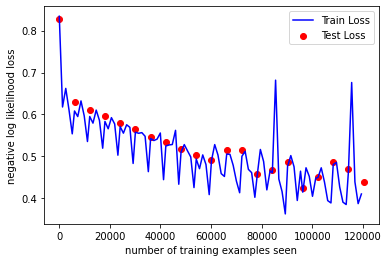

In [30]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [31]:
with torch.no_grad():
    _, _, output = network(test_loader[0][1])

In [32]:
from sklearn.metrics import accuracy_score

h1_accuracy = accuracy_score(output.data.max(1)[1].numpy(), test_loader[0][2].numpy())
h1_accuracy

0.7630968169761273

In [33]:
h1 = copy.deepcopy(network)

# analysis = CompatibilityAnalysis("sweeps", n_epochs, network, train_loader_b, test_loader,
#     batch_size_train, batch_size_test, learning_rate, momentum, lambda_c_stepsize=0.5)
# Here we are setting h2 to be a copy of h1 but in actuality,
# we could pass in any model as h2.
# h2 = MLPClassifier(104, 2, [80, 40, 20, 10])
# h2 = LogisticRegression(104, 2)
h2 = MLPClassifier(104, 2, [5])

analysis = CompatibilityAnalysis("sweeps-adult", n_epochs, h1, h2, train_loader, test_loader,
    batch_size_train, batch_size_test,
    OptimizerClass=optim.SGD,
    optimizer_kwargs={"lr": learning_rate, "momentum": momentum},
    NewErrorLossClass=bcloss.new_error.BCCrossEntropyLoss,
    StrictImitationLossClass=bcloss.StrictImitationCrossEntropyLoss,
    lambda_c_stepsize=0.1,
    get_instance_metadata=get_instance_metadata)